# Classificação de texto com RNN

André Valença, Lucas Valença, Mateus Nascimento

## Setup

In [25]:
import pandas as pd
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Selecionando Datasets e Dataframes

In [107]:
testingDatasets = []
trainingDatasets = []

for i in range(2):
  testingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/test/dialogues_00' + str(i+1) + '.json'))

for i in range(9):
  trainingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_00' + str(i+1) + '.json'))

for i in range(8):
  trainingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_0' + str(i+10) + '.json'))

testingDatasets = pd.concat([testingDatasets[0], testingDatasets[1]])
trainingDatasets = pd.concat([trainingDatasets[0], trainingDatasets[1],trainingDatasets[2],trainingDatasets[3],trainingDatasets[4],trainingDatasets[5],trainingDatasets[6],trainingDatasets[7],trainingDatasets[8],trainingDatasets[9],trainingDatasets[10],trainingDatasets[11],trainingDatasets[12],trainingDatasets[13],trainingDatasets[14],trainingDatasets[15],trainingDatasets[16]])
testingDatasets

dialogue_id                        services  \
0     MUL0484.json             [attraction, train]   
1    PMUL4462.json  [restaurant, taxi, attraction]   
2    PMUL0320.json       [restaurant, taxi, hotel]   
3     MUL2155.json                  [train, hotel]   
4    PMUL0815.json             [restaurant, train]   
..             ...                             ...   
483   MUL0306.json             [restaurant, train]   
484   MUL2228.json                  [train, hotel]   
485   MUL0641.json                  [train, hotel]   
486  PMUL1194.json             [attraction, train]   
487   MUL0527.json             [attraction, train]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [108]:
trainingDatasets

dialogue_id                   services  \
0    PMUL4398.json        [restaurant, hotel]   
1     SNG1013.json                    [hotel]   
2    PMUL0121.json        [restaurant, hotel]   
3    PMUL3484.json  [restaurant, taxi, hotel]   
4     SNG0389.json                    [train]   
..             ...                        ...   
241   SNG1123.json               [attraction]   
242   SNG0925.json                    [hotel]   
243   MUL1853.json        [attraction, train]   
244  WOZ20361.json               [restaurant]   
245  WOZ20469.json               [restaurant]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [109]:
# seleciona no json os campos relevantes. Apenas as falas dos usuários (ignora os do System)
def getDataframes(dataframe):
  entries_classifier = []
  entries_extractor = []

  for turn in dataframe['turns']:
    for entry in turn:
      if entry['speaker'] == 'USER':
        intent = ''
        slot_values = []
        requested_slots = []
        phrase = entry['utterance']
        for frame in entry['frames']:  
          if frame['state']['active_intent'] != 'NONE':
            intent = frame['state']['active_intent']
            slot_values = frame['state']['slot_values']
            requested_slots = frame['state']['requested_slots']
        entries_classifier.append({'entry': phrase, 'intent': intent})
        entries_extractor.append({'entry': phrase, 'intent': intent, 'slot_values': slot_values, 'requested_slots': requested_slots})

  classifier = pd.DataFrame.from_dict(entries_classifier)
  extractor = pd.DataFrame.from_dict(entries_extractor)

  return classifier, extractor

test_classifier, test_extractor = getDataframes(testingDatasets)
train_classifier, train_extractor = getDataframes(trainingDatasets)

test_classifier

,entry,intent
0,I need train reservations from norwich to cambridge,find_train
1,I'd like to leave on Monday and arrive by 18:00.,find_train
2,"Before booking, I would also like to know the travel time, price, and departure time please.",find_train
3,No hold off on booking for now. Can you help me find an attraction called cineworld cinema?,find_attraction
4,"Yes, that was all I needed. Thank you very much!",
...,...,...
7367,"A swimming pool sounds like much more fun, doesn't it?",find_attraction
7368,Any one of those is fine. May I get the entrance fee?,find_attraction
7369,"Yes. I am also looking for a train, leaving on Friday after 10, depart cambridge, going to leicester.",find_train
7370,That will work. Can I have this booking for six people as well as the reference number please?,book_train


In [110]:
trainingDatasets['turns']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Classificando "intents"


### Filtrando "intents" dos outros domínios

In [111]:
# aqueles intents que não interessam ao projeto são marcados como "Invalid"
def recognizeIntents(intent):
  if (intent == 'find_restaurant' or intent == 'book_restaurant'):
    return intent
  return 'Invalid'

train_classifier['intent'] = train_classifier['intent'].apply(recognizeIntents)
test_classifier['intent'] = test_classifier['intent'].apply(recognizeIntents)
train_extractor['intent'] = train_extractor['intent'].apply(recognizeIntents)
test_extractor['intent'] = test_extractor['intent'].apply(recognizeIntents)
train_classifier['intent'].unique()


array(['Invalid', 'find_restaurant', 'book_restaurant'], dtype=object)

In [112]:
train_classifier['intent'].head(16)

0             Invalid
1             Invalid
2             Invalid
3             Invalid
4             Invalid
5             Invalid
6             Invalid
7     find_restaurant
8     find_restaurant
9             Invalid
10            Invalid
11            Invalid
12            Invalid
13            Invalid
14            Invalid
15    find_restaurant
Name: intent, dtype: object

In [113]:
train_classifier['intent'].unique()

array(['Invalid', 'find_restaurant', 'book_restaurant'], dtype=object)

### Criando categorias para os "intents"


In [114]:
# transforma as strings categóricas em números, permitindo processar melhor
train_classifier['intent'] = pd.Categorical(train_classifier['intent'])
train_classifier['intent'] = train_classifier.intent.cat.codes
train_classifier['intent'].unique()

array([0, 2, 1], dtype=int8)

In [115]:
test_classifier['intent'] = pd.Categorical(test_classifier['intent'])
test_classifier['intent'] = test_classifier.intent.cat.codes
test_classifier['intent'].unique()

array([0, 2, 1], dtype=int8)

## Setup input pipeline


In [116]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_classifier['entry'], train_classifier['intent']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_classifier['entry'], test_classifier['intent']))
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'i need a place to dine in the center thats expensive'
label:  0


In [117]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [118]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [119]:
# agora, ele já está com a batch de 64 entradas
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  [b"I'll be headed to the Cherry Hinton, of course."
 b'For the train, no. And I made a mistake. I only need a booking for 1 person.'
 b"That's fine as long as you can book it for four people"
 b"Thank you. I will also need a place to stay in the north. I'd like something that includes free parking."
 b'I am looking for some place to go in the West.'
 b'Can you find one that will take a booking for Thursday and Friday for eight people?'
 b"Woo that's steep but thank you. I also am interested in visiting the museum in the centre area of town, could you give me info on that?"
 b'I am looking to leave Kings Lynn station and arrive by 9:45'
 b'I will be traveling on Saturday.'
 b'No thanks, just grabbing some information for now. Thank you for all of your help.'
 b'I am looking for a 2 star hotel with free wifi.'
 b'I want something expensive.'
 b"I sure hope so. I'd like to find a place to stay, with four stars, in the north."
 b'thanks for your help' b'Thank you for all your help.'

## Criando o encoder (codificador) de texto

Processando o texto para treinamento usando a layer de `TextVectorization`. Essa layer

Criando a layer e passando o mandando o texto para o método `.adapt`:

In [120]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
# pegando nossos textos e criando o vocabulário
encoder.adapt(train_dataset.map(lambda text, label: text))

AttributeError: module 'tensorflow.keras.layers' has no attribute 'TextVectorization'

Primeiros 20 tokens, listados por frequência (exceto o '' e as palavras desconhecidas UKN) 

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

Com o vocabulário estabelecido, a layer agora pode fazer o enconding dos texto para os índices. Os tensors têm, todos, o mesmo tamanho (o 0 completa as frases menores).
Abaixo, pegamos os primeiros três de "example", textos extraídos do train_dataset, para servir de exemplo.
Cada palavra recebe um valor numérico, que pode ser reconvertido em palavras.

In [ ]:
# como se pode ver, cada número representa uma palavra
encoded_example = encoder(example)[:3].numpy()
encoded_example

In [ ]:
example.numpy()[:3]

Pontuação e capitalização são perdidas na reconversão.

In [ ]:
# em vocab[encoded_example[n]]), passamos o valor numérico
# de cada palavra, que é mapeado em vocab
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

## Criando o modelo

O modelo para treino. Entram frases com o tamanho padded e, dentro, são transformadas em vetores de tamanho 64. Passa por algumas funções de ativação e vai devolver, na previsão (.predict), um dos intents.

In [26]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 138,499
Trainable params: 138,499
Non-trai

Compile o modelo Keras para configurar o processo de treinamento:

In [27]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=["mae", "acc"]
              )

## Treinando o modelo

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/6
888/888 [==============================] - 42s 34ms/step - loss: 0.3697 - mae: 0.5690 - acc: 0.8669 - val_loss: 0.3066 - val_mae: 0.5245 - val_acc: 0.8865
Epoch 2/6
888/888 [==============================] - 27s 31ms/step - loss: 0.3069 - mae: 0.5690 - acc: 0.8817 - val_loss: 0.2826 - val_mae: 0.5245 - val_acc: 0.8964
Epoch 3/6
888/888 [==============================] - 28s 31ms/step - loss: 0.2908 - mae: 0.5690 - acc: 0.8873 - val_loss: 0.2775 - val_mae: 0.5245 - val_acc: 0.8974
Epoch 4/6
888/888 [==============================] - 28s 31ms/step - loss: 0.2799 - mae: 0.5690 - acc: 0.8902 - val_loss: 0.2801 - val_mae: 0.5245 - val_acc: 0.9005
Epoch 5/6
888/888 [==============================] - 28s 31ms/step - loss: 0.2701 - mae: 0.5690 - acc: 0.8932 - val_loss: 0.2767 - val_mae: 0.5245 - val_acc: 0.8984
Epoch 6/6
888/888 [==============================] - 28s 31ms/step - loss: 0.2621 - mae: 0.5690 - acc: 0.8959 - val_loss: 0.2787 - val_mae: 0.5245 - val_acc: 0.8922


In [26]:
test_loss, test_acc, *catch_other_return = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

888/888 [==============================] - 11s 12ms/step - loss: 0.2472 - mae: 0.5690 - acc: 0.9014
Test Loss: 0.24718961119651794
Test Accuracy: 0.5689960718154907


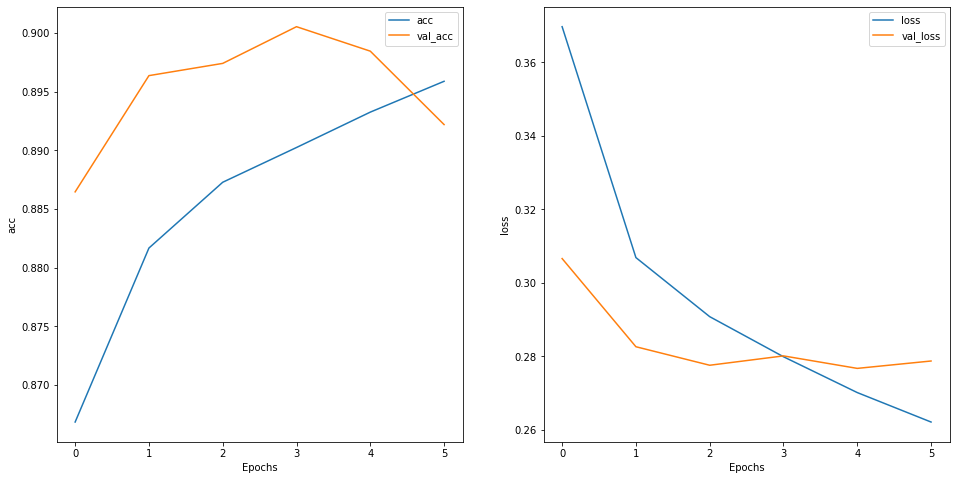

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'acc')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [37]:
predictions = model.predict(['I would like me something to eat'])
c = np.array(['Invalid', 'find_restaurant', 'book_restaurant'])
print(predictions[0])
print(c[np.argmax(predictions[0])])

[1.4664056e-03 5.5676262e-04 9.9797684e-01]
book_restaurant


# Extrator de entidades


In [121]:
train_extractor

,entry,intent,slot_values,requested_slots
0,i need a place to dine in the center thats expensive,Invalid,{},[]
1,"Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation?",Invalid,{},[]
2,"Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel?",Invalid,"{'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[]
3,Yes. Can you book it for me?,Invalid,"{'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[]
4,i want to book it for 2 people and 2 nights starting from saturday.,Invalid,"{'hotel-bookday': ['saturday'], 'hotel-bookpeople': ['2'], 'hotel-bookstay': ['2'], 'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[]
...,...,...,...,...
56771,"Hello, I am looking for a cheap restaurant that serves german food.",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pricerange': ['cheap']}",[]
56772,"Yes, how about portuguese food?",find_restaurant,"{'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[]
56773,It doesn't matter.,find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[]
56774,"I would like the address of Nandos restaurant, please.",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-name': ['nandos'], 'restaurant-pricerange': ['cheap']}",[restaurant-address]


In [123]:
# Ver se mantendo as vírgulas e pontos melhora o desempenho
# train_extractor['entry'] = train_extractor['entry'].apply(lambda x: x.lower().replace('.','').replace(',','').replace(':','').replace(';','').replace('!','').replace('?','').replace('\'',''))
train_extractor['entry'] = train_extractor['entry'].apply(lambda x: x.lower().replace('\'','')).replace('2018', '\'').replace('2019', '\'').replace(';', ',').replace('-', ' ').replace("b&b", "bed and breakfast").replace("b and b", "bed and breakfast").replace("dont care", "dontcare")
# train_extractor['entry'] = train_extractor['entry'].apply(lambda x : x.split())

In [405]:
import re
def replace_sv(te):
    tsv = []
    for i, j in zip(te['entry'], te['slot_values']):
        if j:
            st = i
            num = 0
            for k in j:
                pattern = r'(?<!\[)\b'+j[k][0]+'\\b(?![\w\s]*[\]])'
                st = re.sub( pattern, "["+k+"]", st)
            tsv.append(st)
        else:
            tsv.append('0')
    return tsv
    
train_extractor['phrase'] = replace_sv(train_extractor)
train_extractor

,entry,intent,slot_values,requested_slots,phrase
0,i need a place to dine in the center thats expensive,Invalid,{},[],0
1,"any sort of food would be fine, as long as it is a bit expensive. could i get the phone number for your recommendation?",Invalid,{},[],0
2,"sounds good, could i get that phone number? also, could you recommend me an expensive hotel?",Invalid,"{'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[],"sounds good, could i get that phone number? also, could you recommend me an [hotel-pricerange] [hotel-type]?"
3,yes. can you book it for me?,Invalid,"{'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[],yes. can you book it for me?
4,i want to book it for 2 people and 2 nights starting from saturday.,Invalid,"{'hotel-bookday': ['saturday'], 'hotel-bookpeople': ['2'], 'hotel-bookstay': ['2'], 'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[],i want to book it for [hotel-bookpeople] people and [hotel-bookpeople] nights starting from [hotel-bookday].
...,...,...,...,...,...
56771,"hello, i am looking for a cheap restaurant that serves german food.",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pricerange': ['cheap']}",[],"hello, i am looking for a [restaurant-pricerange] restaurant that serves [restaurant-food] food."
56772,"yes, how about portuguese food?",find_restaurant,"{'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],"yes, how about [restaurant-food] food?"
56773,it doesnt matter.,find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],it doesnt matter.
56774,"i would like the address of nandos restaurant, please.",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-name': ['nandos'], 'restaurant-pricerange': ['cheap']}",[restaurant-address],"i would like the address of [restaurant-name] restaurant, please."


In [404]:
import re
s = "sounds good, could i get that phone number? also, could you recommend me an expensive hotel?"
patt = r"(?<!\[)\b"+"expensive"+"\\b(?![\w\s]*[\]])"
print(patt)
x = re.sub(patt, "["+"hotel-exp"+"]", s)
patt2 = r'(?<!\[)\bhotel\b(?![\w\s]*[\]])'
re.sub(patt2, "[hotel-price]", x)

(?<!\[)\bexpensive\b(?![\w\s]*[\]])


'sounds good, could i get that phone number? also, could you recommend me an [hotel-exp] [hotel-price]?'

In [84]:
import re
# separando em palavras, em pontuação e em espaços em branco
train_extractor['entry'] = [re.findall("\w+|'!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'|\s", i) for i in train_extractor['entry']]
train_extractor
# sem espaço e sem pontuação
# train_extractor['entry'] = [re.findall(r'\w+|\S+', i) for i in train_extractor['entry']]

,entry,intent,slot_values,requested_slots
0,"[i, , need, , a, , place, , to, , dine, , in, , the, , center, , thats, , expensive]",Invalid,{},[]
1,"[any, , sort, , of, , food, , would, , be, , fine, ,, , as, , long, , as, , it, , is, , a, , bit, , expensive, ., , could, , i, , get, , the, , phone, , number, , for, , your, , recommendation, ?]",Invalid,{},[]
2,"[sounds, , good, ,, , could, , i, , get, , that, , phone, , number, ?, , also, ,, , could, , you, , recommend, , me, , an, , expensive, , hotel, ?]",Invalid,"{'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[]
3,"[yes, ., , can, , you, , book, , it, , for, , me, ?]",Invalid,"{'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[]
4,"[i, , want, , to, , book, , it, , for, , 2, , people, , and, , 2, , nights, , starting, , from, , saturday, .]",Invalid,"{'hotel-bookday': ['saturday'], 'hotel-bookpeople': ['2'], 'hotel-bookstay': ['2'], 'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[]
...,...,...,...,...
56771,"[hello, ,, , i, , am, , looking, , for, , a, , cheap, , restaurant, , that, , serves, , german, , food, .]",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pricerange': ['cheap']}",[]
56772,"[yes, ,, , how, , about, , portuguese, , food, ?]",find_restaurant,"{'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[]
56773,"[it, , doesn, ', t, , matter, .]",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[]
56774,"[i, , would, , like, , the, , address, , of, , nandos, , restaurant, ,, , please, .]",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-name': ['nandos'], 'restaurant-pricerange': ['cheap']}",[restaurant-address]


In [85]:
train_extractor = train_extractor[train_extractor['intent']!='Invalid']
test_extractor = test_extractor[test_extractor['intent']!='Invalid']
train_extractor

,entry,intent,slot_values,requested_slots
7,"[no, ,, , but, , i, ', d, , really, , like, , to, , be, , on, , the, , south, , end, , of, , the, , city, ., , do, , any, , of, , those, , fit, , the, , bill, ?]",find_restaurant,{},[]
8,"[no, , i, , don, ', t, , care, , about, , the, , price, ., , which, , one, , do, , you, , recommend, ?]",find_restaurant,{},[]
15,"[yeah, ,, , i, , need, , a, , restaurant, , in, , the, , west, , and, , with, , expensive, , pricing, .]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}",[]
16,"[no, ,, , i, , don, ', t, , have, , a, , preference, ,, , but, , i, , need, , the, , phone, , number, , and, , postcode, .]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}","[restaurant-phone, restaurant-postcode]"
24,"[can, , you, , actually, , look, , up, , a, , restaurant, , for, , me, , as, , well, ?]",find_restaurant,{},[]
...,...,...,...,...
56769,"[what, , is, , there, , phone, , number, ?]",find_restaurant,"{'restaurant-area': ['east'], 'restaurant-food': ['indian'], 'restaurant-name': ['pipasha restaurant'], 'restaurant-pricerange': ['expensive']}",[restaurant-phone]
56771,"[hello, ,, , i, , am, , looking, , for, , a, , cheap, , restaurant, , that, , serves, , german, , food, .]",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pricerange': ['cheap']}",[]
56772,"[yes, ,, , how, , about, , portuguese, , food, ?]",find_restaurant,"{'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[]
56773,"[it, , doesn, ', t, , matter, .]",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[]


In [86]:
pd.set_option('display.max_colwidth', None) 
train_extractor.head(20)

,entry,intent,slot_values,requested_slots
7,"[no, ,, , but, , i, ', d, , really, , like, , to, , be, , on, , the, , south, , end, , of, , the, , city, ., , do, , any, , of, , those, , fit, , the, , bill, ?]",find_restaurant,{},[]
8,"[no, , i, , don, ', t, , care, , about, , the, , price, ., , which, , one, , do, , you, , recommend, ?]",find_restaurant,{},[]
15,"[yeah, ,, , i, , need, , a, , restaurant, , in, , the, , west, , and, , with, , expensive, , pricing, .]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}",[]
16,"[no, ,, , i, , don, ', t, , have, , a, , preference, ,, , but, , i, , need, , the, , phone, , number, , and, , postcode, .]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}","[restaurant-phone, restaurant-postcode]"
24,"[can, , you, , actually, , look, , up, , a, , restaurant, , for, , me, , as, , well, ?]",find_restaurant,{},[]
25,"[it, ', s, , a, , place, , called, , don, , pasquale, , pizzeria, .]",find_restaurant,{'restaurant-name': ['don pasquale pizzeria']},[]
38,"[i, , am, , looking, , for, , a, , restaurant, ., , i, , would, , like, , something, , cheap, , that, , has, , chinese, , food, .]",find_restaurant,"{'restaurant-food': ['chinese'], 'restaurant-pricerange': ['cheap']}",[]
39,"[yes, ,, , could, , you, , make, , a, , reservation, , for, , 1, , at, , 20, :, 00, , on, , saturday, ?]",book_restaurant,"{'restaurant-bookday': ['saturday'], 'restaurant-bookpeople': ['1'], 'restaurant-booktime': ['20:00'], 'restaurant-food': ['chinese'], 'restaurant-name': ['the lucky star'], 'restaurant-pricerange': ['cheap']}",[]
43,"[saturday, , leaving, , cambridge, , anytime, , after, , 20, :, 00, , please]",find_restaurant,{},[]
45,"[i, , am, , also, , looking, , for, , the, , riverside, , brasserie, .]",find_restaurant,{'restaurant-name': ['riverside brasserie']},[]


## Pegando slots/Criando tags


Pega os valores da coluna de slots e cria uma nova coluna chamada "tags" na qual os 'O' significam que uma dada palavra da frase não diz respeito a uma informação relevante. Informações como a área onde está o restaurante e o preço ficam na posição correspondente das suas palavras na frase.

In [102]:
# "restaurant-area",
# "restaurant-bookday",
# "restaurant-bookpeople",
# "restaurant-booktime",
# "restaurant-food",
# "restaurant-name",
# "restaurant-pricerange"
def get_slots(te):

  tags = []

  for i, row in te.iterrows():
    t = []
    for w in row['entry']:
      ap = 'O'
      for j in row['slot_values']:
        if w == row['slot_values'][j][0]:
          ap = j
      t.append(ap)
    
    if all(elem == 'O' for elem in t):
        t = ['0' for e in t]
    
    tags.append(t)
  
  return tags

train_extractor['tags'] = get_slots(train_extractor)

<ipython-input-102-5fad2440e5b9>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_extractor['tags'] = get_slots(train_extractor)


In [105]:
train_extractor.head(50)

,entry,intent,slot_values,requested_slots,tags
7,"[no, ,, , but, , i, ', d, , really, , like, , to, , be, , on, , the, , south, , end, , of, , the, , city, ., , do, , any, , of, , those, , fit, , the, , bill, ?]",find_restaurant,{},[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,"[no, , i, , don, ', t, , care, , about, , the, , price, ., , which, , one, , do, , you, , recommend, ?]",find_restaurant,{},[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
15,"[yeah, ,, , i, , need, , a, , restaurant, , in, , the, , west, , and, , with, , expensive, , pricing, .]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}",[],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, restaurant-area, O, O, O, O, O, restaurant-pricerange, O, O, O]"
16,"[no, ,, , i, , don, ', t, , have, , a, , preference, ,, , but, , i, , need, , the, , phone, , number, , and, , postcode, .]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}","[restaurant-phone, restaurant-postcode]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
24,"[can, , you, , actually, , look, , up, , a, , restaurant, , for, , me, , as, , well, ?]",find_restaurant,{},[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
25,"[it, ', s, , a, , place, , called, , don, , pasquale, , pizzeria, .]",find_restaurant,{'restaurant-name': ['don pasquale pizzeria']},[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
38,"[i, , am, , looking, , for, , a, , restaurant, ., , i, , would, , like, , something, , cheap, , that, , has, , chinese, , food, .]",find_restaurant,"{'restaurant-food': ['chinese'], 'restaurant-pricerange': ['cheap']}",[],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, restaurant-pricerange, O, O, O, O, O, restaurant-food, O, O, O]"
39,"[yes, ,, , could, , you, , make, , a, , reservation, , for, , 1, , at, , 20, :, 00, , on, , saturday, ?]",book_restaurant,"{'restaurant-bookday': ['saturday'], 'restaurant-bookpeople': ['1'], 'restaurant-booktime': ['20:00'], 'restaurant-food': ['chinese'], 'restaurant-name': ['the lucky star'], 'restaurant-pricerange': ['cheap']}",[],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, restaurant-bookpeople, O, O, O, O, O, O, O, O, O, restaurant-bookday, O]"
43,"[saturday, , leaving, , cambridge, , anytime, , after, , 20, :, 00, , please]",find_restaurant,{},[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
45,"[i, , am, , also, , looking, , for, , the, , riverside, , brasserie, .]",find_restaurant,{'restaurant-name': ['riverside brasserie']},[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
# Separando por char e atribuindo as tags a cada char


Criando dicionários que fazem a correspondência entre uma palavra do vocabulário e um index.

In [247]:
from itertools import chain

def get_dict_map(data):
    tok2idx = {}
    idx2tok = {}
    
    vocabulary = []
    for i in data:
        vocabulary += i
    
    vocabulary = set(vocabulary)
    
    tok2idx = {tok:idx for idx, tok in enumerate(vocabulary)}
    idx2tok = {idx:tok for idx, tok in enumerate(vocabulary)}
    
    return tok2idx, idx2tok

token2idx, idx2token = get_dict_map(train_extractor['entry'])
tag2idx, idx2tag = get_dict_map(train_extractor['tags'])

In [252]:
token2idx

{'capable': 0,
 'university': 1,
 'requiring': 2,
 'places': 3,
 'morden': 4,
 'ant': 5,
 'been': 6,
 'dishes': 7,
 'roles': 8,
 'basque': 9,
 'cool': 10,
 'event': 11,
 'knick-knacks': 12,
 'asked': 13,
 'mutliple': 14,
 'nah': 15,
 'brasserie': 16,
 'rest': 17,
 'myself': 18,
 'also': 19,
 'nil': 20,
 'good': 21,
 'attending': 22,
 '(whip': 23,
 'obviously': 24,
 'bill': 25,
 'might': 26,
 'commuting': 27,
 'look': 28,
 'amount': 29,
 'tea': 30,
 'misspelled': 31,
 'specifically': 32,
 '1645': 33,
 'confirmation': 34,
 'its': 35,
 'listed': 36,
 'suppose': 37,
 'avalon': 38,
 'huts': 39,
 'usually': 40,
 'takeaway': 41,
 'hurry': 42,
 'restaurnt': 43,
 '2045': 44,
 'jot': 45,
 'while': 46,
 'most': 47,
 'parks': 48,
 'zizzi': 49,
 'better': 50,
 'cenre': 51,
 'listing': 52,
 'spend': 53,
 'fusion': 54,
 'along': 55,
 'served': 56,
 'liking': 57,
 'scrape': 58,
 'stevenage': 59,
 'idea': 60,
 'hi': 61,
 'graffiti': 62,
 'postcodefood': 63,
 'crossed': 64,
 'cheapish': 65,
 '1330': 66,

Cada palavra agora tem um index, assim como suas tags.

In [275]:
def def_index(data, idx):
    entry_idx = []
    for i in data:
        entry_idx.append([idx.get(item, "No_key") for item in i])
    return entry_idx

train_extractor['entry_idx'] = def_index(train_extractor['entry'], token2idx)
train_extractor['tag_idx'] = def_index(train_extractor['tags'], tag2idx)
train_extractor

<ipython-input-275-a7ad400779e0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_extractor['entry_idx'] = def_index(train_extractor['entry'], token2idx)
<ipython-input-275-a7ad400779e0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_extractor['tag_idx'] = def_index(train_extractor['tags'], tag2idx)


,entry,intent,slot_values,requested_slots,tags,entry_idx,tag_idx
7,"[no, but, id, really, like, to, be, on, the, south, end, of, the, city, do, any, of, those, fit, the, bill]",find_restaurant,{},[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[522, 632, 1938, 190, 1431, 1637, 1516, 1113, 1543, 853, 1960, 1339, 1543, 1520, 490, 1306, 1339, 1817, 505, 1543, 25]","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]"
8,"[no, i, dont, care, about, the, price, which, one, do, you, recommend]",find_restaurant,{},[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[522, 163, 1335, 1983, 1225, 1543, 1622, 1268, 1428, 490, 987, 1988]","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]"
15,"[yeah, i, need, a, restaurant, in, the, west, and, with, expensive, pricing]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}",[],"[O, O, O, O, O, O, O, west, O, O, expensive, O]","[683, 163, 1853, 479, 1435, 951, 1543, 626, 82, 1030, 1394, 133]","[160, 160, 160, 160, 160, 160, 160, 97, 160, 160, 142, 160]"
16,"[no, i, dont, have, a, preference, but, i, need, the, phone, number, and, postcode]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}","[restaurant-phone, restaurant-postcode]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[522, 163, 1335, 861, 479, 1193, 632, 163, 1853, 1543, 1522, 258, 82, 1189]","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]"
24,"[can, you, actually, look, up, a, restaurant, for, me, as, well]",find_restaurant,{},[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[395, 987, 116, 28, 945, 479, 1435, 1985, 984, 1564, 1702]","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]"
...,...,...,...,...,...,...,...
56769,"[what, is, there, phone, number]",find_restaurant,"{'restaurant-area': ['east'], 'restaurant-food': ['indian'], 'restaurant-name': ['pipasha restaurant'], 'restaurant-pricerange': ['expensive']}",[restaurant-phone],"[0, 0, 0, 0, 0]","[1143, 577, 418, 1522, 258]","[14, 14, 14, 14, 14]"
56771,"[hello, i, am, looking, for, a, cheap, restaurant, that, serves, german, food]",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pricerange': ['cheap']}",[],"[O, O, O, O, O, O, cheap, O, O, O, german, O]","[327, 163, 1613, 1576, 1985, 479, 1634, 1435, 784, 1555, 1923, 1488]","[160, 160, 160, 160, 160, 160, 126, 160, 160, 160, 5, 160]"
56772,"[yes, how, about, portuguese, food]",find_restaurant,"{'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],"[O, O, O, portuguese, O]","[528, 1644, 1225, 213, 1488]","[160, 160, 160, 103, 160]"
56773,"[it, doesnt, matter]",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],"[0, 0, 0]","[1777, 1136, 1334]","[14, 14, 14]"


In [96]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## Padding


Uniformizando o tamanho dos arrays.

In [276]:
def get_max(col):
    LE = 0
    for i in col:
        if len(i) > LE:
            LE = len(i)
    
    return LE

def get_pad_train_test_val(data_group):

    # pegando o tamanho da maior das frases
    n_token = get_max(data_group['entry'])
    n_tag = get_max(data_group['tags'])

    #Padding tokens (X var)    
    tokens = data_group['entry_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Padding Tags (y var) e convertendo-a para on-hot-encoding (0s e 1s)
    tags = data_group['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Separando train, test e validation
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(train_extractor)


train_tokens length: 8120 
train_tokens length: 8120 
test_tokens length: 1203 
test_tags: 1203 
val_tokens: 2707 
val_tags: 2707


In [362]:
train_tokens[0]

array([ 163,   19,  217, 1431, 1637, 1287,  951, 1543, 1436, 1339, 1995,
         35,   35,   35,   35,   35,   35,   35,   35,   35,   35,   35,
         35,   35,   35,   35,   35,   35,   35,   35,   35,   35,   35,
         35,   35,   35], dtype=int32)

In [363]:
train_tags[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [306]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.utils import plot_model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [326]:
input_dim = len(train_extractor['entry'].to_list())+1
output_dim = 64
input_length = max([len(s) for s in train_extractor['entry_idx']])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)


input_dim:  12031 
output_dim:  64 
input_length:  36 
n_tags:  161


## Modelo


In [307]:
# Many-to-many. Devolver tag (y) para um token (X) consumido a cada passo
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [327]:
model = get_bilstm_lstm_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 36, 64)            769984    
                                                                 
 bidirectional_1 (Bidirectio  (None, 36, 128)          66048     
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 36, 64)            49408     
                                                                 
 time_distributed (TimeDistr  (None, 36, 161)          10465     
 ibuted)                                                         
                                                                 
Total params: 895,905
Trainable params: 895,905
Non-trainable params: 0
_________________________________________________________________


### Treinando modelo

In [330]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

In [334]:
!pip install pydot
!brew install graphviz

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> Updated Formulae
Updated 131 formulae.
==> Deleted Formulae
soundpipe
==> Updated Casks
Updated 29 casks.

We (and Apple) do not provide support for this old version.
You will encounter build failures with some formulae.
Please create pull requests instead of asking for help on Homebrew's GitHub,
Twitter or any other official channels. You are responsible for resolving
any issues you experience while you are running this
old version.

==> Downloading https://ghcr.io/v2/homebrew/core/m4/manifests/1.4.19
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/m4/blobs/sha256:0cf53207764a231
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/autoconf/manifests/

######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/readline/blobs/sha256:0af6c77e4
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/sqlite/manifests/3.36.0
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/sqlite/blobs/sha256:f96b12f3fe9
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/xz/manifests/5.2.5
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/xz/blobs/sha256:44483961b5d2b53
==> Downloading from https://pkg-containers.githubuser

In [331]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 36, 64)            769984    
                                                                 
 bidirectional_2 (Bidirectio  (None, 36, 128)          66048     
 nal)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 36, 64)            49408     
                                                                 
 time_distributed_1 (TimeDis  (None, 36, 161)          10465     
 tributed)                                                       
                                                                 
Total params: 895,905
Trainable params: 895,905
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) a

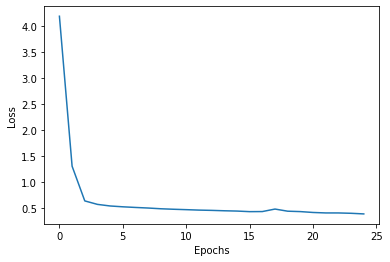

In [364]:
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [365]:
# tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
# train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

# At every execution model picks some random test sample from test set.
i = np.random.randint(0, test_tokens.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([test_tokens[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, test_tokens.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_tokens[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


NameError: name 'y_test' is not defined